In [12]:
from abc import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import MultiStepLR

## **One-demensional pure jump equation**

T = 1, X0 = 1, λ = 0.3, µ_ϕ = 0.4, σ_ϕ = 0.25

dividing time into equal intervals with N = 50

neural network with 2 hidden layers, each with 16 neurons, and ReLU activation function

In [13]:
device = torch.device('cuda:0')

In [14]:
class model(nn.Module) :
    def __init__(self, hidden_dims) :
        super(model, self).__init__()
    
        self.layers = []
        for i in range(len(hidden_dims)-1) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :
            nn.init.xavier_uniform_(layer.weight)

        self.act = nn.ReLU()
    
    def forward(self, x) :
        for layer in self.layers[:-1] :
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x

In [15]:
network = model(hidden_dims=[2,16,16,1]).to(device)

In [16]:
def compute_loss(network, t0, x0, g_function, dt, lambda_, mu_phi, sigma_phi, N_steps=50):

    device = x0.device
    x = x0
    t = t0
    
    total_loss = 0.0

    for n in range(N_steps):
        jump_occurence = (torch.rand_like(x) < lambda_ * dt).float()
        jump_size = torch.normal(mean=mu_phi, std=sigma_phi, size=x.shape).to(device)
        actual_jump = jump_size * jump_occurence

        # Y_n process
        x.requires_grad_()
        y = network(torch.cat([t, x], dim=1))
        
        dydx = torch.autograd.grad(
            outputs=y, inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True
        )[0]
        x = x.detach()

        # u_hat = u(t, X*e^z) - u(t, X)
        with torch.no_grad():
            x_jumped = x * torch.exp(actual_jump)
            y_jumped = network(torch.cat([t, x_jumped], dim=1))
        
        u_hat = (y_jumped - y) * jump_occurence

        exp_val = np.exp(mu_phi + 0.5 * sigma_phi**2)
        compensator_Y = lambda_ * x * (exp_val - 1) * dydx * dt

        # t_n+1의 Y 예측값
        y_pred_next = y + u_hat - compensator_Y
        
        # X_n process
        x_next = x + x * (torch.exp(actual_jump) - 1) - lambda_ * x * (exp_val - 1) * dt

        t = t + dt
        x = x_next
        
        # 신경망을 통한 다음 Y
        y_next_nn = network(torch.cat([t, x], dim=1))

        total_loss += torch.mean((y_next_nn - y_pred_next)**2)

    g_target = g_function(x)
    y_N = network(torch.cat([t, x], dim=1))
    
    terminal_loss = torch.mean((y_N - g_target)**2)

    return total_loss + terminal_loss

In [17]:
EPOCHS = 10000

In [18]:
optimizer = optim.Adam(network.parameters(), lr=1e-3)
scheduler = MultiStepLR(optimizer, milestones=[2000,5000,7000], gamma=0.2)

In [19]:
T = 1.0
N_STEPS = 50
dt = T / N_STEPS
lambda_ = 0.3
mu_phi = 0.4
sigma_phi = 0.25

In [20]:
# 터미널 조건 함수
g = lambda x: x

In [21]:
def sample_batch(batch_size=100, d=1):
    x0 = torch.ones(batch_size, d).to(device) 
    t0 = torch.zeros(batch_size, 1).to(device)
    return t0, x0

In [ ]:
loss_list = []
network.train()

for epoch in range(1, EPOCHS+1):
    optimizer.zero_grad()

    t_batch, x_batch = sample_batch()

    loss = compute_loss(network, 
                        t_batch, 
                        x_batch, 
                        g_function=g, 
                        dt=dt,
                        lambda_=lambda_,
                        mu_phi=mu_phi,
                        sigma_phi=sigma_phi,
                        N_steps=N_STEPS)

    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_list.append(loss.item())
    
    if epoch % 1000 == 0:
        print(f"EPOCH : {epoch}/{EPOCHS} | Loss : {loss.item():.7f}")

print('Training Finished.')

EPOCH : 1000/10000 | Loss : 0.0001286


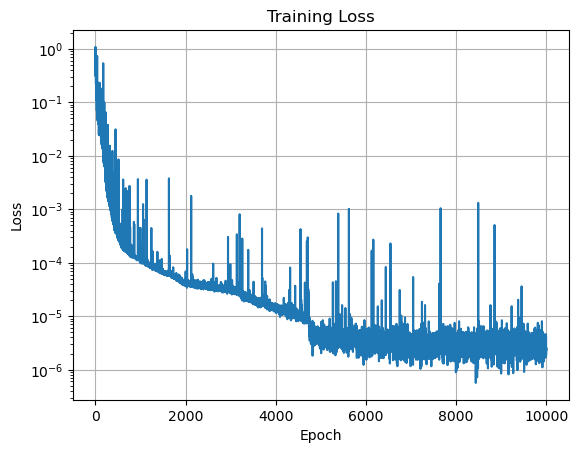

In [12]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.yscale('log')       # 이렇게 하면 작은 범위에서 loss가 어떻게 줄어드는지 볼 수 있음.
plt.show()

In [13]:
@torch.no_grad()
def simulate_trajectories(network, dt, lambda_, mu_phi, sigma_phi, N_steps=50, samples=5, d=1):
    device = next(network.parameters()).device
    network.eval()

    t = torch.zeros(samples, 1).to(device)
    x = torch.ones(samples, d).to(device)

    t_list = [t]
    x_list = [x]
    y_list = [network(torch.cat([t, x], dim=1))]

    for n in range(N_steps):
        jump_occurence = (torch.rand_like(x) < lambda_ * dt).float()
        jump_size = torch.normal(mean=mu_phi, std=sigma_phi, size=x.shape).to(device)
        actual_jump = jump_size * jump_occurence

        sum_of_jumps = x * (torch.exp(actual_jump) - 1)

        exp_val = np.exp(mu_phi + 0.5 * sigma_phi**2)
        compensator_X = lambda_ * x * (exp_val - 1) * dt

        x = x + sum_of_jumps - compensator_X
        t = t + dt

        y = network(torch.cat([t, x], dim=1))
        
        t_list.append(t)
        x_list.append(x)
        y_list.append(y)

    t_path = torch.cat(t_list, dim=1).cpu().numpy()
    x_path = torch.cat(x_list, dim=1).cpu().numpy()
    y_path = torch.cat(y_list, dim=1).cpu().numpy()

    return t_path, x_path, y_path

In [15]:
with torch.no_grad():
    t0 = torch.zeros(1, 1).to(device)
    x0 = torch.ones(1, 1).to(device) 
    input_tx = torch.cat([t0, x0], dim=1)

    u_01 = network(input_tx)
    print(f"u(0, X0=1) = {u_01.item():.5f}")

u(0, X0=1) = 0.99782


Calculating for 100 samples...
Calculating for 3000 samples...
Calculating for 5000 samples...
Calculating for 7000 samples...
Calculating for 10000 samples...


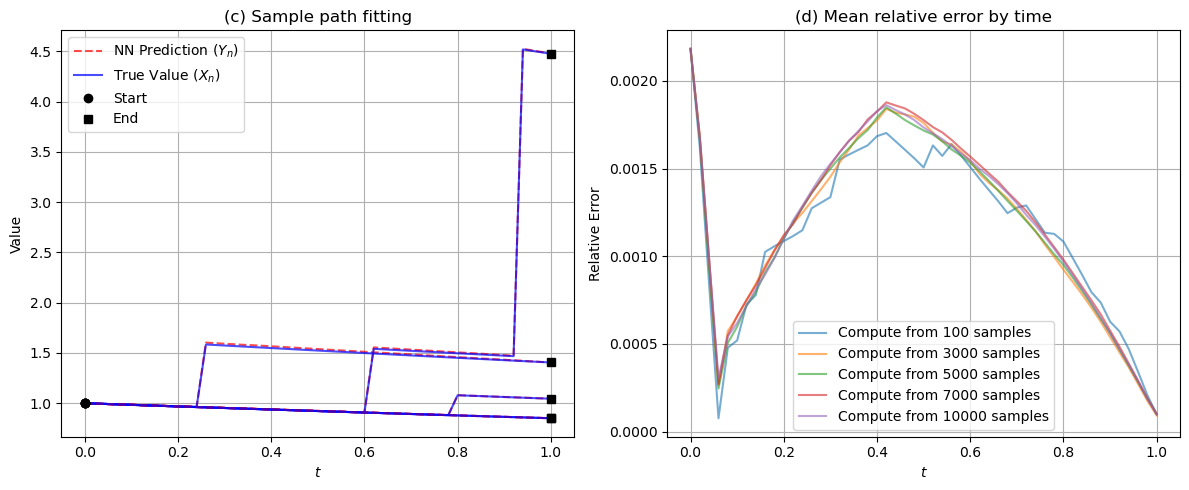

In [22]:
num_sample_paths = 5

t_path, x_path, y_path = simulate_trajectories(network, dt, 
                                               lambda_=lambda_, mu_phi=mu_phi, sigma_phi=sigma_phi, 
                                               N_steps=N_STEPS, 
                                               samples=num_sample_paths)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

for i in range(num_sample_paths):
    if i == 0:

        plt.plot(t_path[i], y_path[i], 'r--', alpha=0.7, label='NN Prediction ($Y_n$)')
        plt.plot(t_path[i], x_path[i], 'b-', alpha=0.7, label='True Value ($X_n$)')
    else:
        plt.plot(t_path[i], y_path[i], 'r--', alpha=0.7)
        plt.plot(t_path[i], x_path[i], 'b-', alpha=0.7)

plt.plot(t_path[:, 0], x_path[:, 0], 'ko', markersize=6, label='Start')
plt.plot(t_path[:, -1], x_path[:, -1], 'ks', markersize=6, label='End')

plt.xlabel('$t$')
plt.ylabel('Value')
plt.title('(c) Sample path fitting')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sample_sizes = [100, 3000, 5000, 7000, 10000]

for num_samples in sample_sizes:
    print(f"Calculating for {num_samples} samples...")
    t_path_err, x_path_err, y_path_err = simulate_trajectories(network, dt, 
                                                               lambda_=lambda_, 
                                                               mu_phi=mu_phi, 
                                                               sigma_phi=sigma_phi,
                                                               N_steps=N_STEPS, 
                                                               samples=num_samples)
    
    relative_error = np.abs(y_path_err - x_path_err) / (np.abs(x_path_err) + 1e-8)
    mean_relative_error = np.mean(relative_error, axis=0)
    plt.plot(t_path_err[0], mean_relative_error, alpha=0.6, label=f'Compute from {num_samples} samples')

plt.xlabel('$t$')
plt.ylabel('Relative Error')
plt.title('(d) Mean relative error by time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
@torch.no_grad()
def calculate_relative_l2_error(network, dt, lambda_, mu_phi, sigma_phi, N_steps=50, num_samples=10000):
    device = next(network.parameters()).device
    network.eval()

    t = torch.zeros(num_samples, 1).to(device)
    x = torch.ones(num_samples, 1).to(device)
    
    sum_of_mse = 0.0
    sum_of_true_ms_norm = 0.0

    for n in range(N_steps):
        y_pred = network(torch.cat([t, x], dim=1))
        y_true = x  # u(t,x) = x

        mse = torch.mean((y_pred - y_true)**2)
        true_ms_norm = torch.mean(y_true**2)

        sum_of_mse += mse * dt
        sum_of_true_ms_norm += true_ms_norm * dt

        jump_occurence = (torch.rand_like(x) < lambda_ * dt).float()
        jump_size = torch.normal(mean=mu_phi, std=sigma_phi, size=x.shape).to(device)
        actual_jump = jump_size * jump_occurence
        
        sum_of_jumps = x * (torch.exp(actual_jump) - 1)
        exp_val = np.exp(mu_phi + 0.5 * sigma_phi**2)
        compensator_X = lambda_ * x * (exp_val - 1) * dt
        
        x = x + sum_of_jumps - compensator_X
        t = t + dt

    relative_l2_error = torch.sqrt(sum_of_mse) / torch.sqrt(sum_of_true_ms_norm)
    
    return relative_l2_error.item()

print("Calculating final relative L2 error...")
final_error = calculate_relative_l2_error(network, 
                                          dt, 
                                          lambda_, 
                                          mu_phi, 
                                          sigma_phi,
                                          N_steps=N_STEPS,
                                          num_samples=100000)

print(f"\nFinal Relative L2 Error: {final_error:.4%}")

Calculating final relative L2 error...

Final Relative L2 Error: 0.4584%


jump occurence 늘려보기
그리고 100차원에서도 